# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

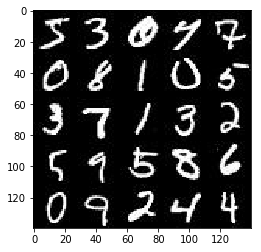

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

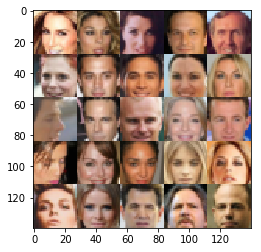

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim),name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    #learning_rate = 0.1
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    leaky_relu = lambda x: tf.maximum(alpha*x, x)
    def conv(inputs, filters, kernel_size,strides, batch_norm = True):
        outputs = tf.layers.conv2d(inputs, filters, kernel_size,strides, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
    
    with tf.variable_scope('discriminator',reuse=reuse):
        conv1 = conv(images, 64, 5, 2, batch_norm = False)
        conv2  = conv(conv1, 128, 5, 2)
        conv3  = conv(conv2, 256, 5, 2)

        flat = tf.contrib.layers.flatten(conv3)
        
        #h1 = tf.layers.dense(flat, 128, activation=None)
        #h1 = tf.maximum(alpha*h1, h1)
        #dropout = tf.nn.droput(h1, keep_prob=0.5)
        
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    leaky_relu = lambda x: tf.maximum(alpha*x, x)
    def deconv(inputs, filters, kernel_size,strides, batch_norm = True):
        outputs = tf.layers.conv2d_transpose(inputs, filters, kernel_size,strides, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return outputs

    with tf.variable_scope('generator',reuse= not is_train):
        h1 = tf.layers.dense(z, 7*7*512,activation=None)
        h1 = tf.reshape(h1,[-1,7,7,512])
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = leaky_relu(h1)
 
        conv1 = deconv(h1, 256, 5, 1, batch_norm = is_train)
        conv1 = leaky_relu(conv1)
        conv2  = deconv(conv1, 128, 5, 2, batch_norm = is_train)
        conv2 = leaky_relu(conv2)
        conv3  = deconv(conv2, out_channel_dim, 5, 2, batch_norm = False)        
        out = tf.nn.tanh(conv3)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    d_gen_logits = generator(input_z,out_channel_dim)

    _, d_real_logits = discriminator(input_real, reuse=False)
    _, d_fake_logits = discriminator(d_gen_logits, reuse=True)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,labels=tf.ones_like(d_real_logits) * (1 - smooth)))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_logits)))
  
    d_gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_logits)))
    
    d_dis_loss = d_real_loss + d_fake_loss
    return d_dis_loss, d_gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list = g_vars)                                                                           

        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
show_n_images = 25
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_dis_loss, d_gen_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt, g_opt = model_opt(d_dis_loss, d_gen_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images *2.0
                batch_z = np.random.uniform(-1.0,1.0, size=(batch_size,z_dim))
                _ = sess.run(g_opt, feed_dict={input_z:batch_z,input_real:batch_images})
                _ = sess.run(d_opt, feed_dict={input_z:batch_z,input_real:batch_images})
                
                if steps % 100 == 0:
                    train_loss_d = sess.run(d_dis_loss, feed_dict={input_z:batch_z,input_real:batch_images})
                    train_loss_g = sess.run(d_gen_loss, feed_dict={input_z:batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.4833


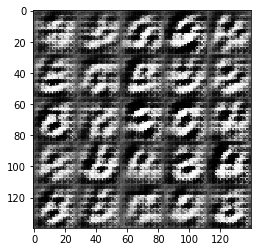

Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.0472


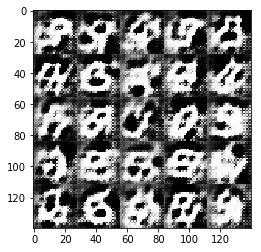

Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.7639


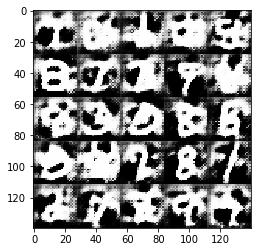

Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 0.9261


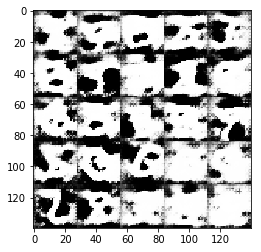

Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 1.1502


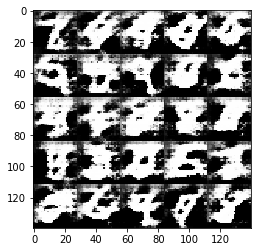

Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.0834


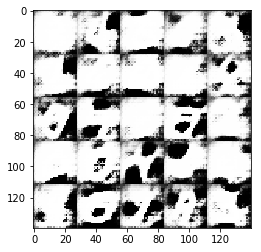

Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.1121


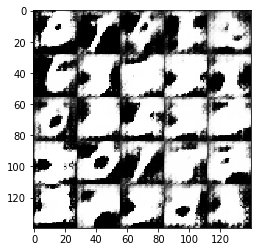

Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.0214


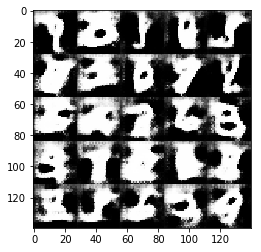

Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 1.1638


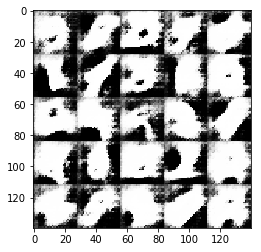

Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.9418


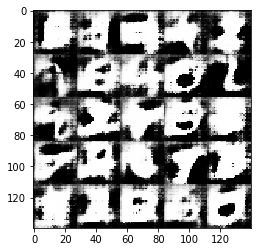

Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 0.7643


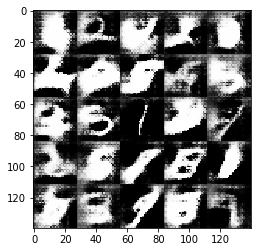

Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.7027


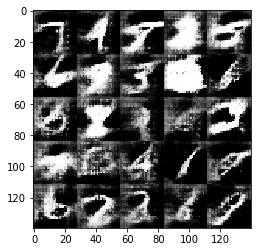

Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.1525


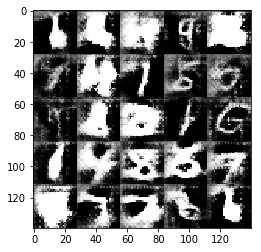

Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.7177


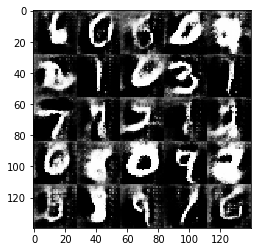

Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 1.4668


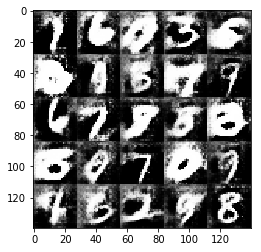

Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.8778


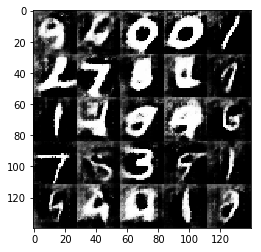

Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.2935


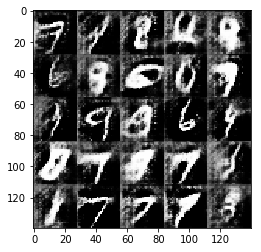

Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 1.7576


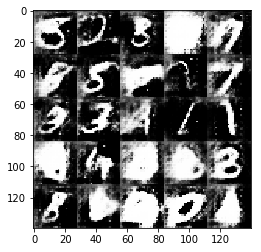

Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.6891


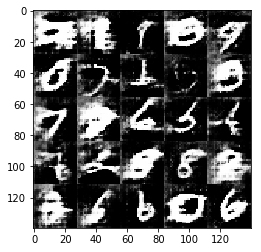

Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.3684


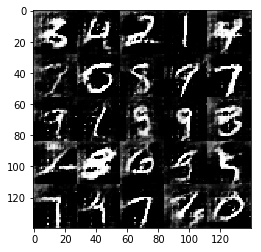

Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.9703


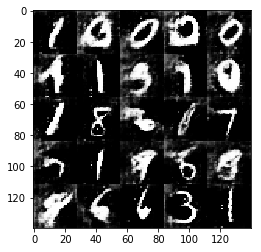

Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 1.2721


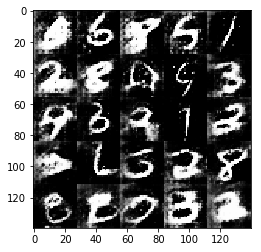

Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.7998


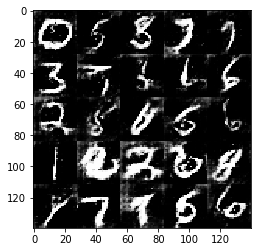

Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.4634


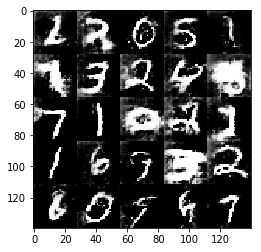

Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.3827


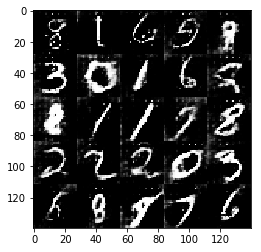

Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 1.0691


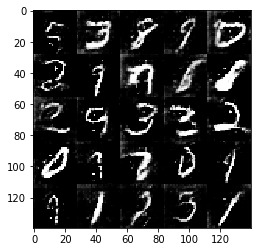

Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.3020


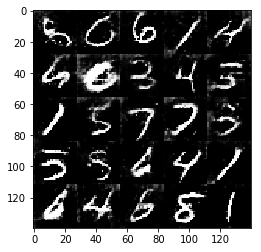

Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.2989


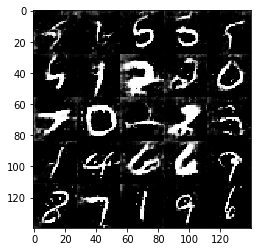

Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.7929


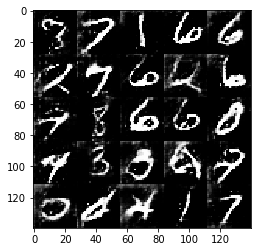

Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 1.0628


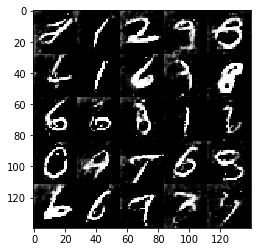

Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.5236


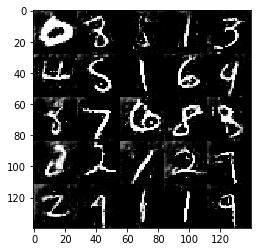

Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7505


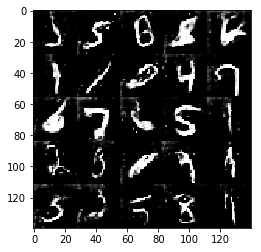

Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 1.5302


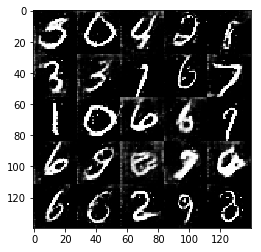

Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.6936


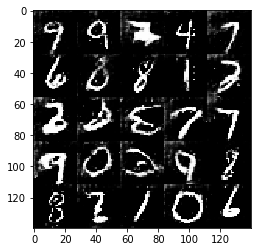

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.4531


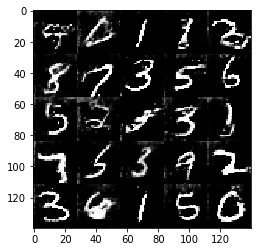

Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.2532


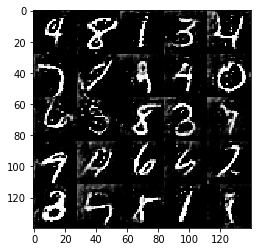

In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0008
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 4.5839


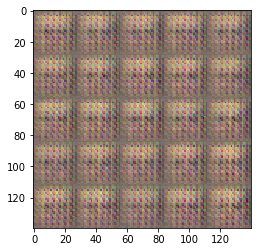

Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 4.8112


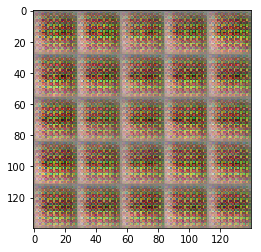

Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 2.2121


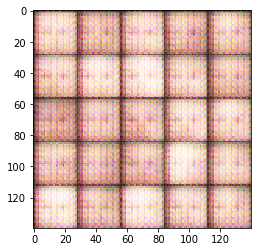

Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 3.8107


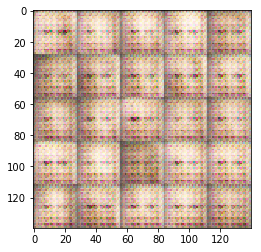

Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 2.1376


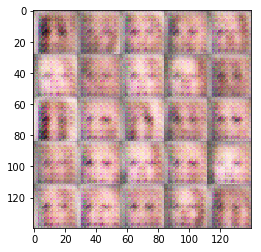

Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.8750


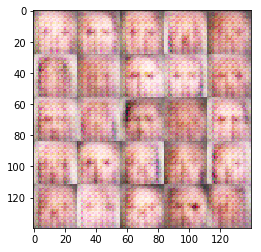

Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 2.5408


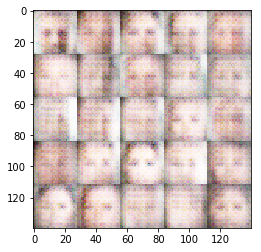

Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.8438


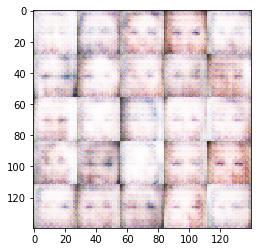

Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.6237


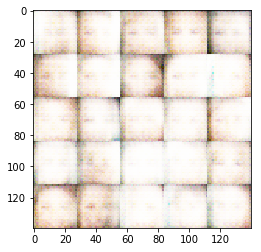

Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.6327


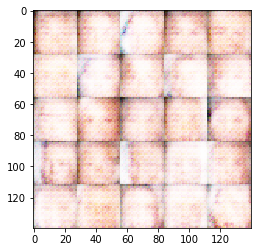

Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.9529


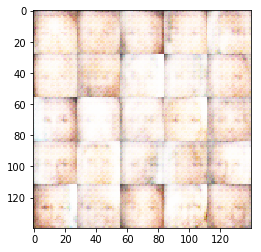

Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.7477


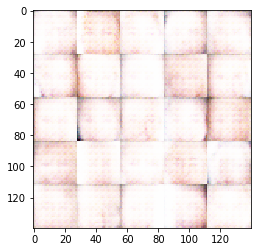

Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.7048


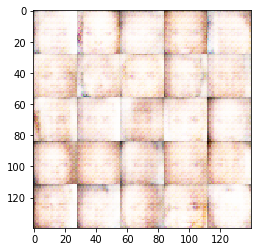

Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.4171


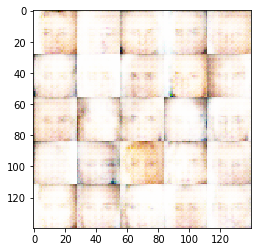

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.3545


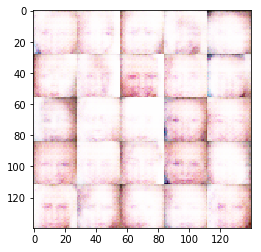

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0765


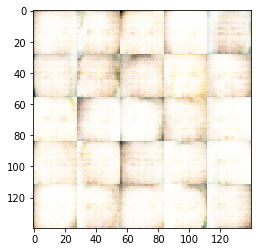

Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.4668


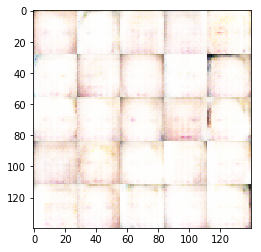

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.2431


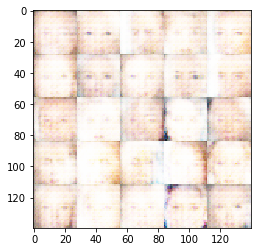

Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.2125


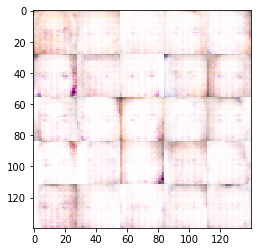

Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.7882


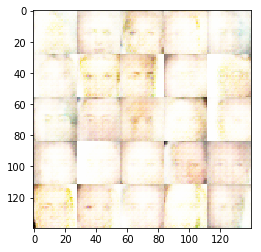

Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9758


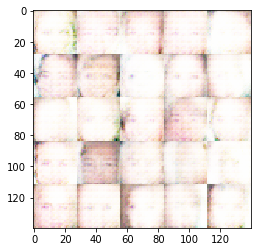

Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.0703


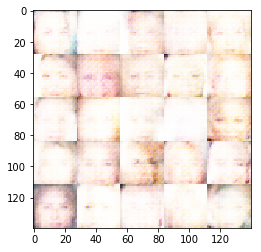

Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.0953


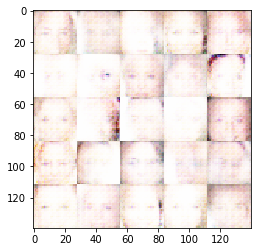

Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.5027


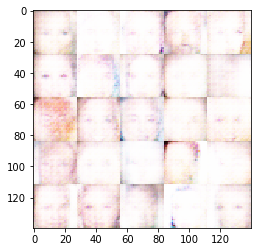

Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.3180


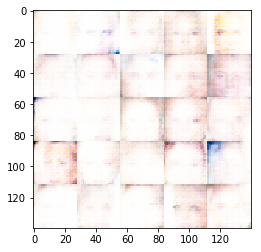

Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.0243


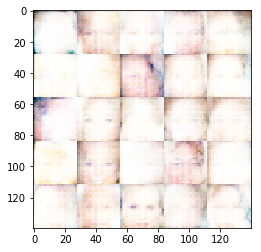

Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.1103


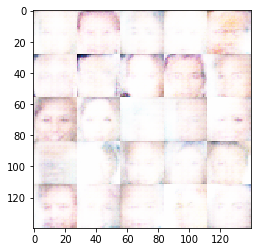

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.3227


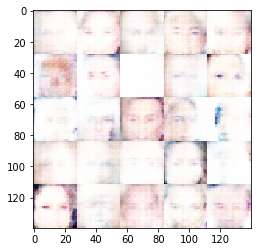

Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.3871


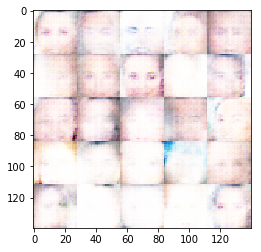

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.2628


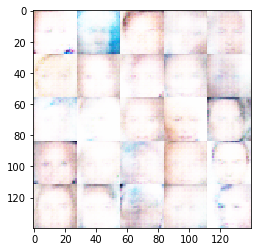

Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.3433


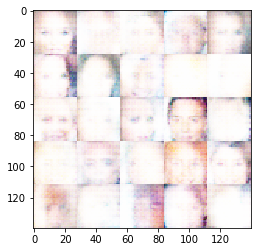

Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9558


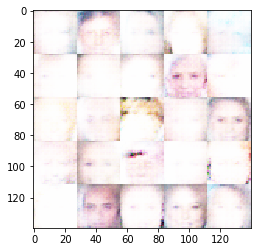

Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.4412


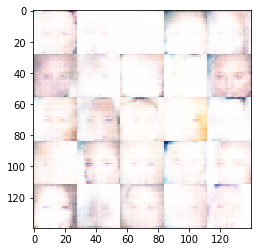

Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0794


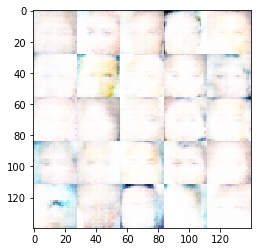

Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.1684


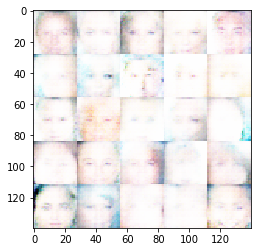

Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.1462


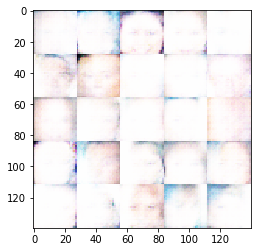

Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.3142


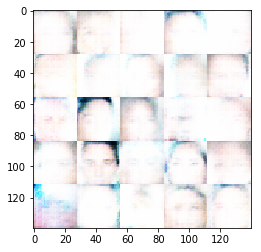

Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.4748


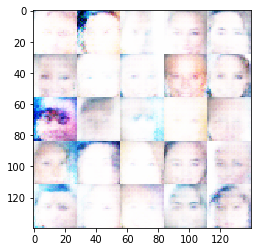

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.0915


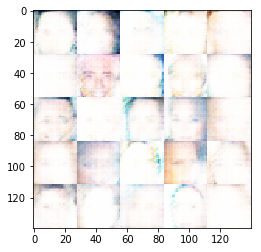

Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.4296


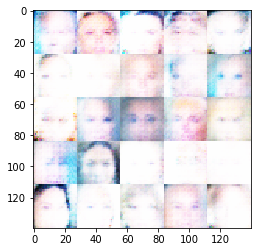

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.2744


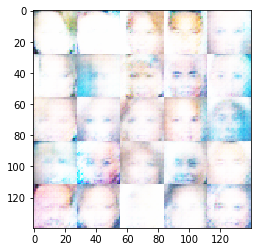

Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.3926


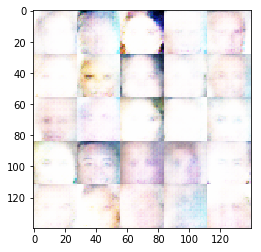

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.1675


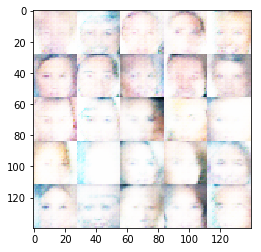

Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.1368


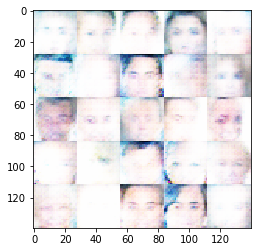

Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.5162


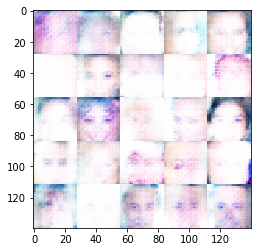

Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.7163


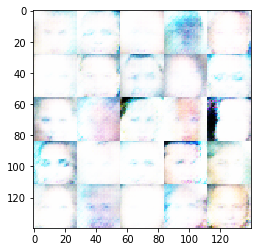

Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.3938


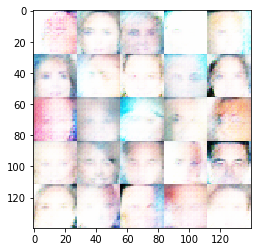

Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.5051


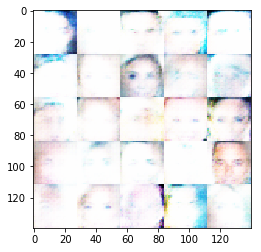

Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.3516


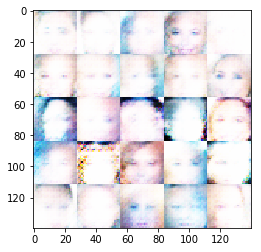

Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.8152


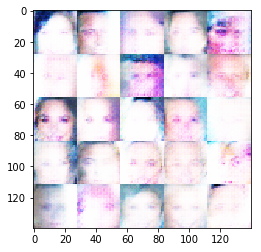

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.4817


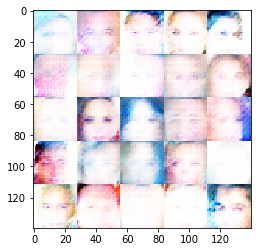

Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.4173


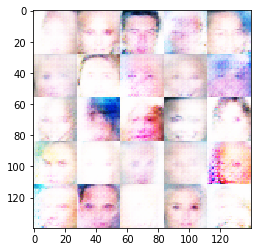

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.7083


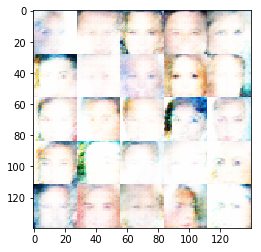

Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.3965


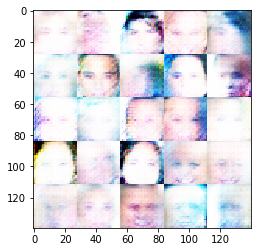

Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.2932


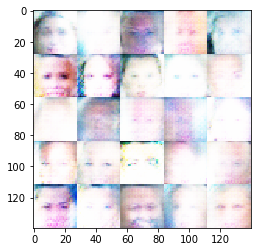

Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.4476


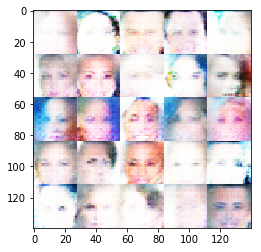

Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.6409


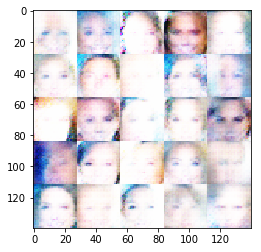

Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9512


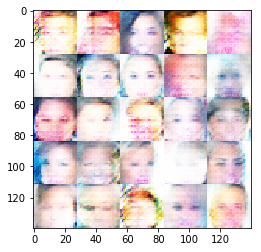

Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.9420


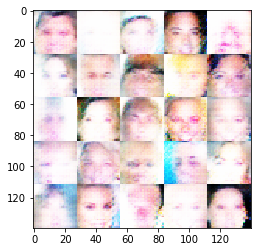

Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.1533


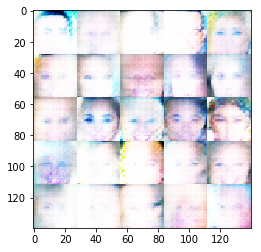

Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.2476


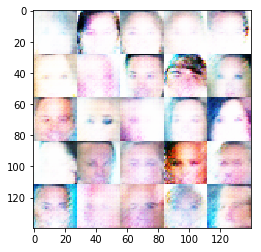

Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0499


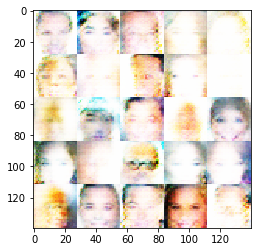

Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.9992


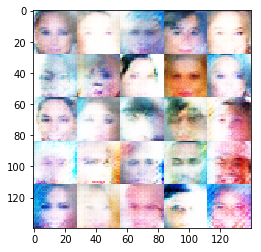

In [13]:
batch_size = 32
z_dim = 128
learning_rate = .0001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.